### This notebook is used for creating the dataset of real guppies images to test the YOLO model on

In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
import csv  
from io import BytesIO
from IPython import display

import torch
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
import h5py

from tensorflow.keras.layers import StringLookup

from ML_helper import *
from helpers.corrections import *
from helpers.image_loading import *
from helpers.handling import *
from helpers.identity_isolation import *

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

relevant_characters =  {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'B',10:'F',11:'G',12:'K',13:'N',14:'O',15:'P',16:'R',17:'S',18:'V',19:'W',20:'Y', 21:''}


client = vision.ImageAnnotatorClient()

c:\Users\newc6448\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Load in our data

In [2]:
folders = ['Manually_Labelled/New/TY1202','Manually_Labelled/New/LL1201','Manually_Labelled/New/CA1006','Manually_Labelled/New/CA1106','Manually_Labelled/New/CA1208', 'Manually_Labelled/New/CA1207' ,'Manually_Labelled/New/CA1206','Manually_Labelled/New/CA1209jpegs JB']

bucket_name = "guppy_images"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

file_list = []
for folder in folders:
    s_file_list = storage_client.list_blobs(bucket_name,prefix=folder)
    s_file_list = [file.name for file in s_file_list]
    file_list.extend(s_file_list)

In [3]:
def ReturnFinalImage(image_in_bytes, client, padx=100, pady=80, verbose=False):
    client = vision.ImageAnnotatorClient()

    # Initial prediction (including title and date) and ID bounding box.
    output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=verbose)

    # Returns the combined bounding box of the ID
    identity_box = combine_boxes(character_boxes, added_length=100)
    
    # Reduce the image to just the ID
    reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

    # Mask and removes things surrounding the ID (white background, title and date etc,)
    masked_image = mask_and_remove(reduced_frame, verbose=verbose)

    # Remove deltas
    if len(character_boxes) == 3:
        final_image = remove_deltas(masked_image, width=15, padx=padx + 80, pady=pady//2, verbose=verbose)

    else:
        final_image = remove_deltas(masked_image, width=15, padx=padx, pady=pady//2, verbose=verbose)

    # Put the final images through some checks.
    # Checks include removing faint images, and images with abnormally large sizes along either axis
    shape = np.shape(final_image)
    counts = np.count_nonzero(final_image)
    valid_test = counts / (shape[0] * shape[1])

    if valid_test > 0.065 and shape[0] > 250 and shape[1] < 1000:
        corrected_label = FindErrors(output_string, verbose=verbose)
        if verbose: 
            print('Initial string', output_string)
            print('Corrected label', corrected_label)
        return corrected_label, final_image

    else:
        if verbose: print('Failed checking. Ignoring image')
        return 1
    



def extract_ID(file_list):
    #extract the IDs from the filenames.
    
    id_list = []
    for f in file_list:
        f = f.split('/')[-1].split('.')[0]
        
        if 's' in f:
            f = f.split('s')[0]

        if '(' in f: #this is something where the file has a (1) in it.
            f = f.split('(')[0][:-1]
            
        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

IDs = np.array(extract_ID(file_list))

maxlen = np.max([len(IDs[i]) for i in range(len(IDs))])

1B2K 1B2K


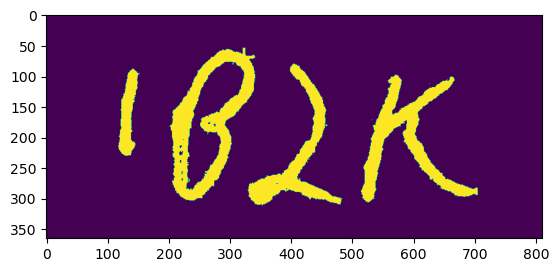

In [4]:
i=0
file = file_list[i]
image_in_bytes = RetreiveImage(file)
output_string, final_image = ReturnFinalImage(image_in_bytes, client, verbose=False)

pred = output_string.split('-')[1]

plt.imshow(final_image)
print(pred, IDs[i])

In [5]:
string_to_vector(IDs[i], relevant_characters, max_len=maxlen), IDs[i]

(array([ 1,  9,  2, 12, 21, 21, 21, 21]), '1B2K')

In [6]:
h5f = h5py.File(('test_dataset.h5'), 'w')

image_width, image_height = 256, 64
   
file = file_list[0]
image_in_bytes = RetreiveImage(file)
output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

label_ID = IDs[0]

first_image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
first_label = string_to_vector(label_ID, relevant_characters,max_len=maxlen)[None]
first_label_googpred = string_to_vector(output_string.split('-')[1], relevant_characters,max_len=maxlen)[None]

h5f.create_dataset('images', data=first_image, compression="gzip", chunks=True, maxshape=(None,image_height,image_width))
h5f.create_dataset('labels', data=first_label, compression="gzip", chunks=True, maxshape=(None,maxlen))
h5f.create_dataset('labels_googpred', data=first_label_googpred, compression="gzip", chunks=True, maxshape=(None,maxlen))


<HDF5 dataset "labels_googpred": shape (1, 8), type "<i4">

In [7]:
some_im_IDs = []
some_label_IDs = []

idx = np.arange(0, len(file_list))
np.random.shuffle(idx)


for i in range(len(file_list)):
    st = str(i)
    try: 
        image_in_bytes = RetreiveImage(file_list[idx[i]])
        output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

        if output_string == 1: continue


        image = preprocess_image(im_ID[...,None],(image_width,image_height))[None,...,0]
        label = string_to_vector(IDs[idx[i]], relevant_characters, max_len=maxlen)[None]
        label_goog = string_to_vector(output_string.split('-')[1], relevant_characters, max_len=maxlen)[None]


        h5f['images'].resize((h5f['images'].shape[0] + 1),axis=0)
        h5f['images'][-1:] = image

        h5f['labels'].resize((h5f['labels'].shape[0] + 1),axis=0)
        h5f['labels'][-1:] = label

        h5f['labels_googpred'].resize((h5f['labels_googpred'].shape[0] + 1),axis=0)
        h5f['labels_googpred'][-1:] = label_goog


        st += ' success'

    except: st += ' fail'
    print(st)


print(f"a success rate of {len(h5f['images']) / len(file_list)  * 100} %")

h5f.close()
    

0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
16 success
17 success
18 success
19 success
20 fail
22 success
23 success
24 success
25 success
26 success
27 success
28 success
29 success
30 success
31 success
32 success
33 success
34 success
35 success
36 success
37 fail
38 success
39 success
41 success
42 fail
43 success
44 success
45 success
46 success
47 fail
48 success
49 success
50 success
51 success
52 success
53 success
54 success
55 success
56 success
57 success
59 success
60 success
61 success
62 success
63 success
64 success
65 success
66 success
67 success
68 success
69 success
70 success
71 success
72 fail
73 success
74 success
75 success
76 success
77 success
78 success
79 success
80 success
81 success
82 fail
83 success
84 success
85 fail
87 success
88 success
89 success
90 success
91 success
92 success
93 success
94 success
95 success
96 success
97 succe

############################# DATASET CREATED #####################################


Everything under here is old crap

(array([[14,  9,  3, 10,  0,  0,  0,  0]], dtype=int64),
 array([[14,  9,  3, 10,  0,  0,  0,  0]], dtype=int64))

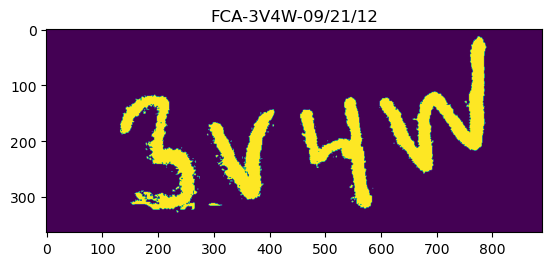

In [52]:
plt.imshow(im_ID)
plt.title(output_string)
label_goog, label

Text(0.5, 1.0, 'MCA-6Y7V-08/21/12')

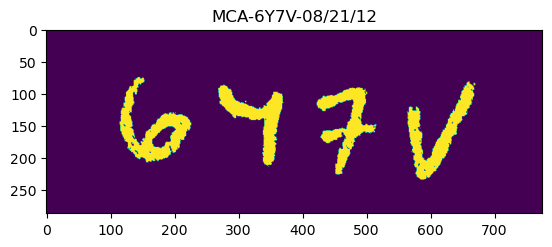

In [17]:
file = file_list[209]
image_in_bytes = RetreiveImage(file)
output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

plt.imshow(im_ID)
plt.title(output_string)

In [ ]:
characters = []
for i in IDs:
    for j in i:
        if j not in characters:
            characters.append(j)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

max_len = len(max(IDs, key=len))
model = tf.keras.Sequential()
model.add(char_to_num)
model.add(num_to_char)
model.build(input_shape=(1,1))
model.save('stringlookups.h5') #need to save these lookup tables for use in model.
model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [18]:
new_files = ListAvaliableFiles("guppy_images", "Manually_Labelled/New")
new_jpg_files = [ x for x in new_files if "JPG" in x ]

np.random.shuffle(new_jpg_files)

0 (326, 771)
1 (295, 687)
2 (344, 879)
3 (307, 822)
4 (296, 774)
5 (320, 733)
6 (351, 849)
7 (365, 751)
8 (348, 771)
9 (362, 769)
10 (305, 761)
11 (302, 737)
12 (343, 758)
13 (314, 767)
14 (352, 809)
15 (353, 826)
16 (384, 822)
17 (337, 840)
18 (325, 827)
19 (348, 791)
20 (349, 878)
22 (303, 697)
23 (376, 877)
24 (318, 749)
25 (372, 858)
26 (331, 875)
27 (377, 826)
28 (328, 770)
29 (337, 839)
30 (313, 764)
31 (395, 898)
32 (369, 863)
34 (368, 809)
35 (325, 633)
36 (346, 813)
37 (325, 705)
38 (322, 723)
39 (357, 829)
40 (332, 738)
41 (340, 744)
42 (297, 743)
43 (323, 791)
44 (321, 772)
45 (317, 746)
46 (344, 701)
47 (315, 762)
48 (322, 821)
49 (323, 764)
50 (351, 818)
51 (338, 832)
52 (346, 802)
53 (350, 862)
54 (337, 744)
55 (350, 587)
56 (342, 733)
57 (336, 871)
58 (313, 751)
59 (378, 834)
60 (318, 748)
61 (307, 666)
62 (320, 665)
63 (305, 741)
64 (392, 886)
65 (314, 722)
66 (319, 903)
67 (326, 784)
68 (322, 744)
69 (320, 759)
70 (321, 642)
71 (331, 788)
72 (327, 716)
73 (340, 729)
74

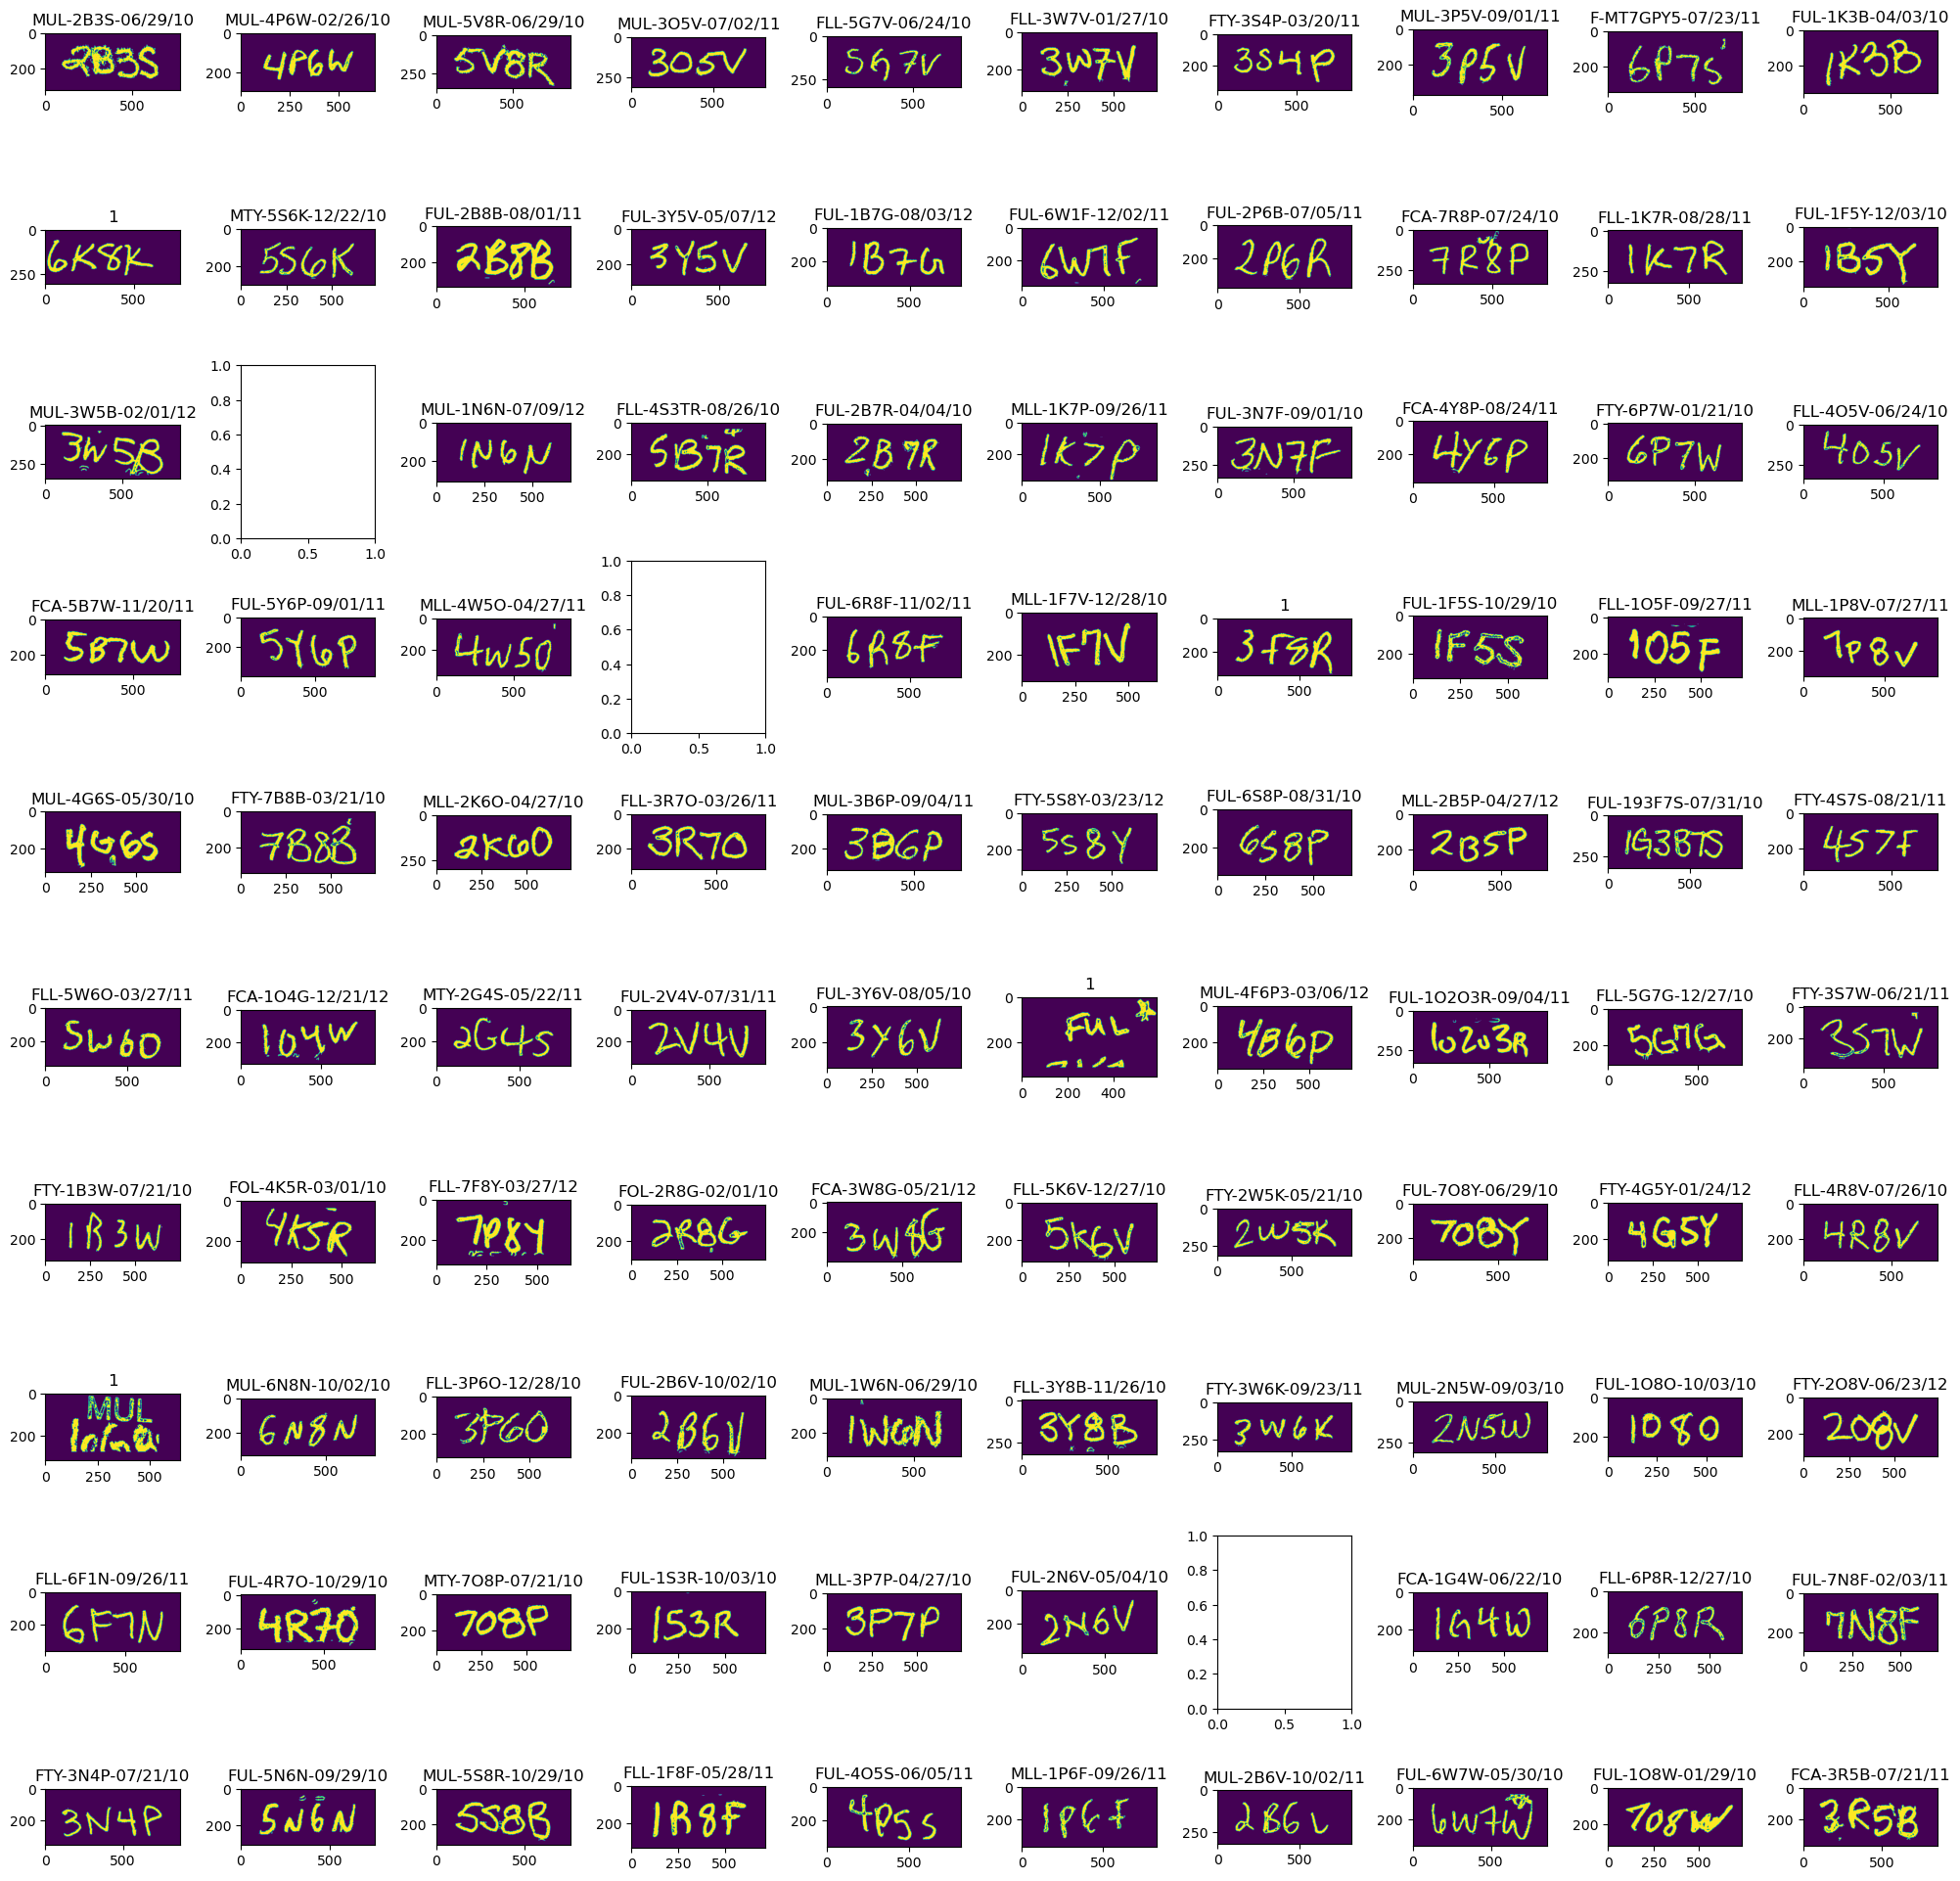

In [27]:
client = vision.ImageAnnotatorClient()

fig,ax = plt.subplots(10,10, figsize=(20,20))
for i in range(100):
    image_in_bytes = RetreiveImage(new_jpg_files[i])
    try:
        output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)
        # ax[i].imshow(im_ID)
        # ax[i].set_title(output_string)
        ax[i//10, i%10].imshow(im_ID)
        ax[i//10, i%10].set_title(output_string)
        print(i, im_ID.shape)
    except:
        pass

plt.tight_layout()

Text(0.5, 1.0, 'FTY-3S4P-03/20/11')

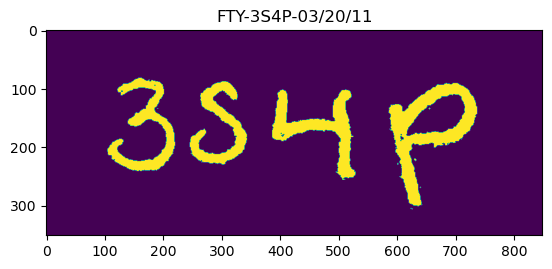

In [20]:
file = new_jpg_files[6]
image_in_bytes = RetreiveImage(file)

output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

plt.imshow(im_ID)
plt.title(output_string)
# print(file)

## Lets isolate single characters

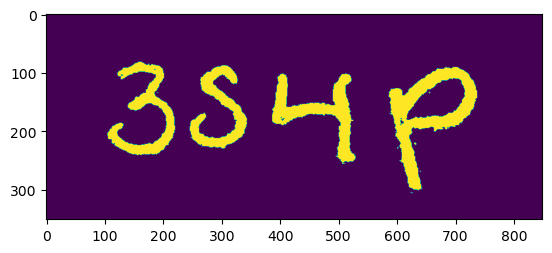

In [21]:
plt.imshow(im_ID)

In [22]:
num_components, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(im_ID))

In [23]:
rel_components = np.where(stats[:,-1] >800)[0][1:]

In [24]:
stats = stats[rel_components]

# stats = np.sort(stats, axis=0) #sort by their x coordinate to get in right order

In [25]:
characters = []
pad = 10

for i in range(rel_components.shape[0]):

    y_start,x_start,width,height = stats[i,:4]

    char = labels[x_start-pad:x_start+height+pad,y_start-pad:y_start+width+pad] == rel_components[i]

    characters.append(char)

print(characters)
characters = np.array(characters)
characters = characters[np.argsort(stats[:,0])]
fig,ax = plt.subplots(1,rel_components.shape[0],figsize=(10,5))
for i in range(rel_components.shape[0]):
    ax[i].imshow(characters[i])
    ax[i].axis('off')

[array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

### now need to pad somewhat and get into 28$\times$28 format

In [ ]:
samples = torch.zeros((len(characters), 1, 28, 28))

for i, char in enumerate(characters):


    #here we should really scale up if w and h are too small.
    h,w = char.shape
    pooler = torch.nn.AvgPool2d(10)

    
    eg = np.uint8(char)

    eg = cv2.dilate(eg, np.ones((5,5)), iterations = 1)

    if h>w:
        resize_h = 260
        resize_w = int(w * (resize_h/h))
        pad = (resize_h - resize_w)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((10,10),(pad,280-resize_w-pad)), mode = 'constant', constant_values = 0))
        
    else:
        resize_w = 260
        resize_h = int(h * (resize_w/w))
        pad = (resize_w - resize_h)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((pad,280-resize_h-pad),(10,10),), mode = 'constant', constant_values = 0))

    samples[i] = pooler(char.unsqueeze(0).unsqueeze(0))

samples = samples / torch.amax(samples, dim = (1,2,3), keepdim = True)

samples = samples* 255


In [ ]:
import os
import torch

letter_model_path = 'letter_model.pth'
if os.path.exists(letter_model_path):
    cnn_let = torch.load(letter_model_path)
else:
    print(f"Error: {letter_model_path} not found")

import torch

letter_model_path = 'letter_model.pth'
if os.path.exists(letter_model_path):
    cnn_let = torch.load(letter_model_path)
else:
    print(f"Error: {letter_model_path} not found")

cnn_num = torch.load('number_model.pth')

relevant_characters =  ['0','1','2','3','4','5','6','7','8','B','F','G','K','N','O','P','R','S','V','W','Y'] 

nums = relevant_characters[:9]
letters = relevant_characters[9:]

def preds_to_char(preds, chars):
    pred_idx = torch.max(preds, 1)[1].data.numpy().squeeze()
    return np.array([chars[i] for i in pred_idx])

FileNotFoundError: [Errno 2] No such file or directory: 'letter_model.pth'

In [ ]:
letter_preds = cnn_let(samples[::2])[0]
number_preds = cnn_num(samples[1::2])[0]

letter_preds_decoded = preds_to_char(letter_preds, letters)
number_preds_decoded = preds_to_char(number_preds, nums)

a = len(number_preds_decoded)
b = len(letter_preds_decoded)
string = ''
for i in range(a):
    string += number_preds_decoded[i]
    string += letter_preds_decoded[i]
if b > a:
    string += letter_preds_decoded[-1]



fig,ax = plt.subplots(1,len(samples),figsize=(10,10))
for i in range(len(samples)):
    ax[i].imshow(samples[i,0],cmap='gray')
    ax[i].set_title(string[i])
    ax[i].axis('off')



NameError: name 'cnn_let' is not defined

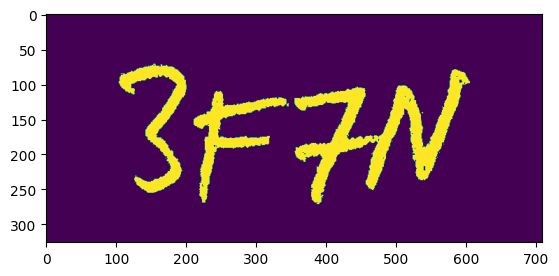

In [ ]:
file = new_jpg_files[6]
image_in_bytes = RetreiveImage(file)

output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

plt.imshow(im_ID)

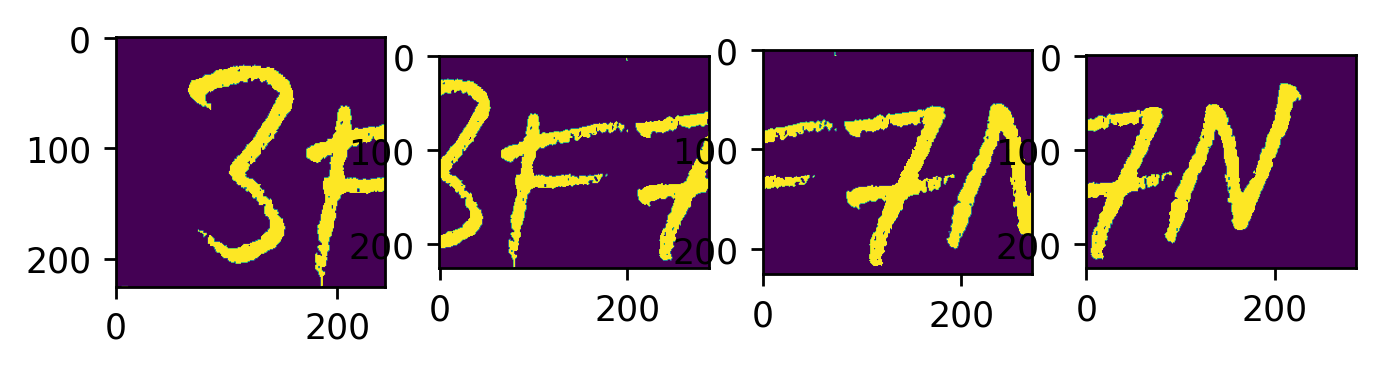

In [ ]:
file = new_jpg_files[6]
image_in_bytes = RetreiveImage(file)

output_string, frame, para_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

# ordered_para_boxes

fig,ax = plt.subplots(1,len(para_boxes),dpi=250)

for i, para_box in enumerate(para_boxes):
    box = combine_boxes([para_box])

    %matplotlib inline
    ID = extract_ID_handwriting(frame, box, verbose=False)
        
    ax[i].imshow(ID)

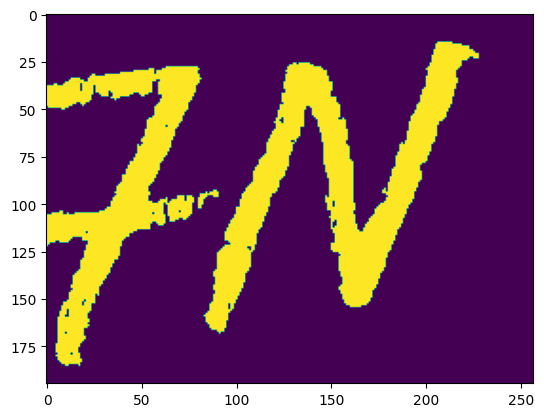

In [ ]:
for n, row in enumerate(ID):
        if np.array_equal(row, np.zeros(len(row))):
            try:
                ID = np.delete(ID, n, axis=0)
            except:
                pass

for j, column in enumerate(np.transpose(ID)):
    if np.array_equal(column, np.zeros(len(column))):
        try:
            ID = np.delete(ID, j, axis=1)
        except:
            pass
        
plt.imshow(ID)